<a href="https://colab.research.google.com/github/katemartian/Photometry_data_processing/blob/master/Photometry_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Photometry data processing</center></h1>

If you want to use this code, please cite our Jove paper:

__Martianova, E., Aronson, S., Proulx, C.D.__ [Multi-Fiber Photometry to Record Neural Activity in Freely Moving Animal.](https://www.jove.com/video/60278/multi-fiber-photometry-to-record-neural-activity-freely-moving). _J. Vis. Exp._ (152), e60278, doi:10.3791/60278 (2019).

# Set up workspace

Run the cell (Shift+Enter or Ctrl+Enter) to mount disk if you work in Google Colab

Change working directory

Download photometry_functions.py file from https://github.com/katemartian/Photometry_data_processing and run the following cell 

OR

Run the code cells at the end of the notebook

In [1]:
%run photometry_functions.py

Import libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Your data

Copy our example.csv file from https://github.com/katemartian/Photometry_data_processing 

OR

Use your data

In [3]:
# # Folder with your files
# folder = '/Users/brynnharrisshanks/Documents/GitHub/Photometry_data_processing/data/' # Modify it depending on where your file is located
# # File name
# file_name = 'cfc_2046.csv'   # Change to your data file
# # Read the file
# df = pd.read_csv(folder+file_name,index_col=False) # Adjust this line depending on your data file
# df.head()

Choose from the dataframe calcium dependent and independent signals

In [8]:
# Load data
def load_photometry_data(file_path):
    df = pd.read_csv(file_path).rename(columns={
        "AIn-1 - Dem (AOut-1)": "ACC control",
        "AIn-1 - Dem (AOut-2)": "ACC 465",
    })
    return df.dropna()

# Bin data at 10ms (100Hz)
def bin_data(df, bin_size=0.01):
    df["Time_bin"] = df["Time(s)"].round(2)  # Create a new column for binning
    df_binned = df.groupby("Time_bin").agg({  # Aggregate using mean
        "ACC control": "mean",
        "ACC 465": "mean",
    }).reset_index()
    
    df_binned.rename(columns={"Time_bin": "Time(s)"}, inplace=True)  # Rename back
    return df_binned

# Apply low-pass filter at 1.7Hz
def low_pass_filter(data, cutoff=1.7, fs=100):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(2, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Define file path
folder = '/Users/brynnharrisshanks/Documents/GitHub/Photometry_data_processing/data/'  # Modify it depending on your location
file_name = 'cfc_2046.csv'  # Update to your dataset
file_path = folder + file_name

# Load and process data
df = load_photometry_data(file_path)
df = bin_data(df)  # Bin data at 10ms

# Apply low-pass filter to each signal
for col in ["ACC control", "ACC 465"]:
    df[col] = low_pass_filter(df[col])

# Display first few rows to confirm
df.head()

,Time(s),ACC control,ACC 465
0,0.12,0.514544,0.719307
1,0.13,0.514060,0.719291
2,0.14,0.513570,0.719272
3,0.15,0.513077,0.719252
4,0.16,0.512582,0.719229


In [10]:
# Adjust these lines depending on your dataframe
raw_reference = df['ACC control'][1:]
raw_signal = df['ACC 465'][1:]

Plot the raw data

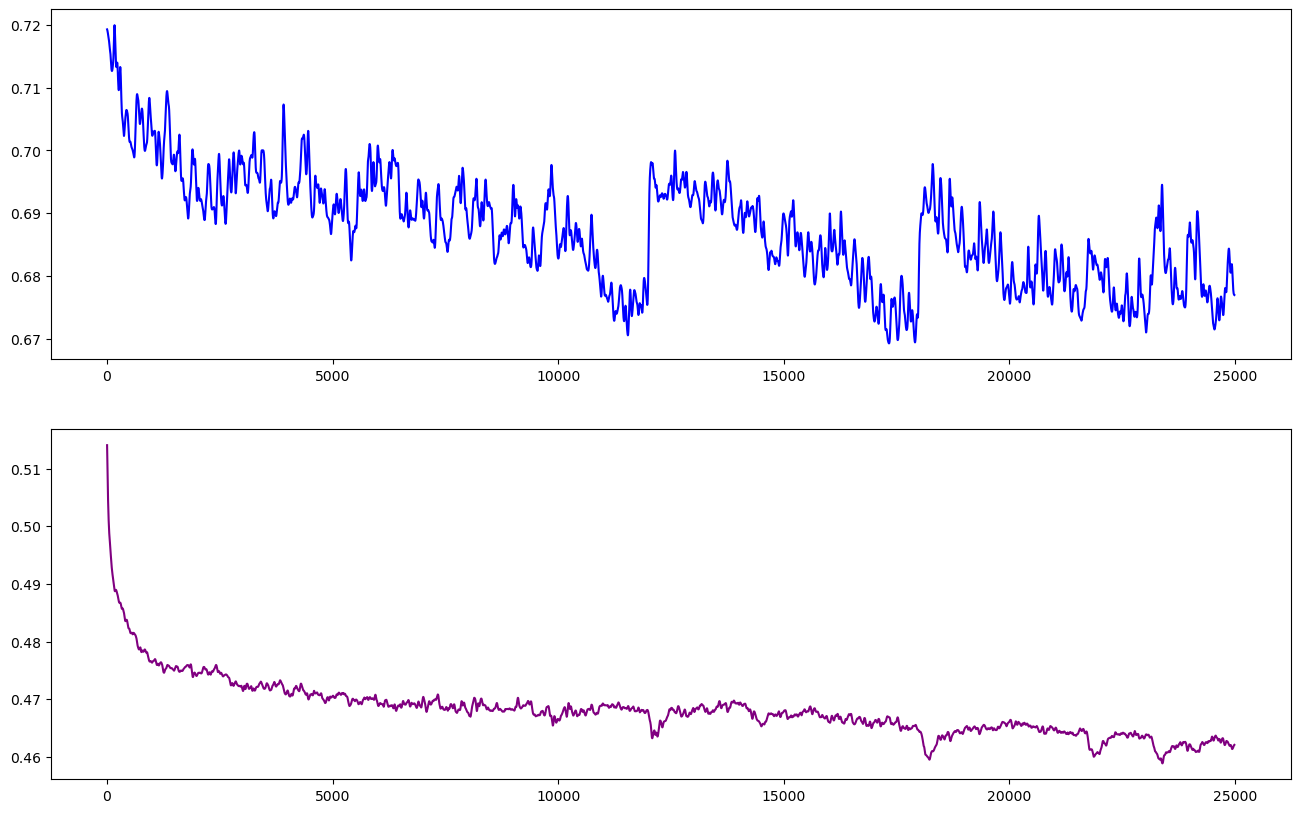

In [11]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(raw_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(raw_reference,'purple',linewidth=1.5)

# Use function get_zdFF to calculate z-dF/F

Call the function

In [12]:
zdFF = get_zdFF(raw_reference,raw_signal)

Plot the result

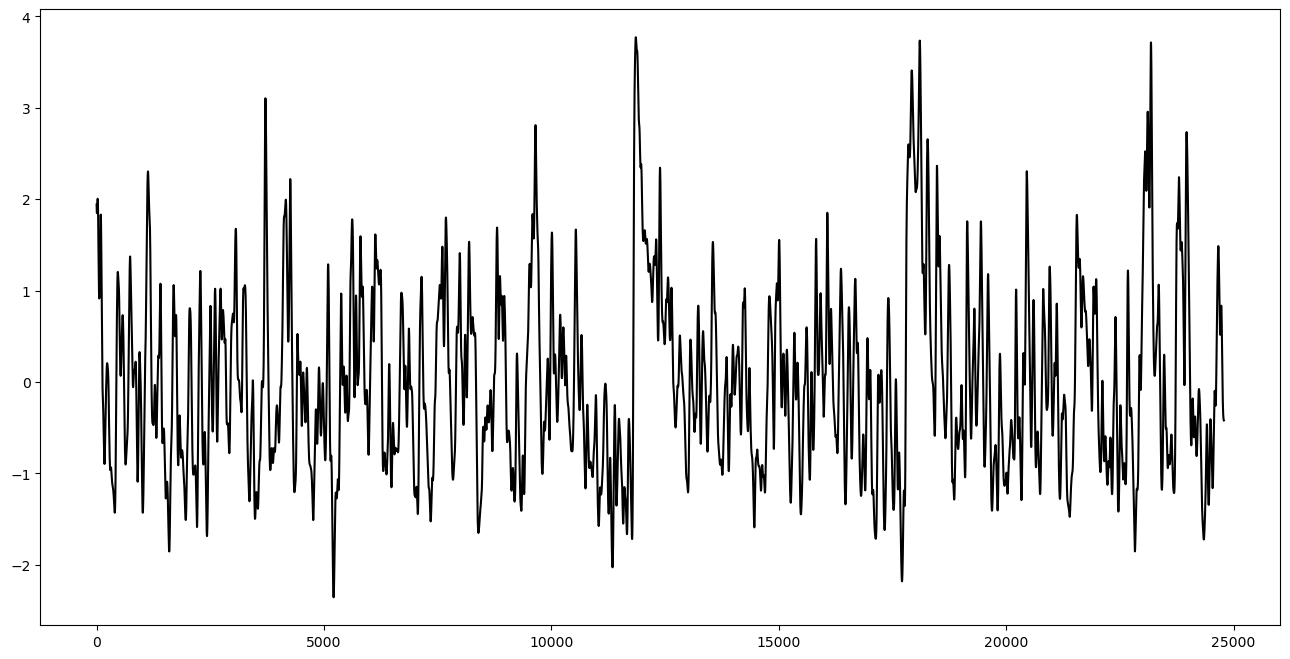

In [13]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(zdFF,'black',linewidth=1.5)

# Analysis step by step

### Smooth

In [14]:
smooth_win = 10
smooth_reference = smooth_signal(raw_reference, smooth_win)
smooth_signal = smooth_signal(raw_signal, smooth_win)

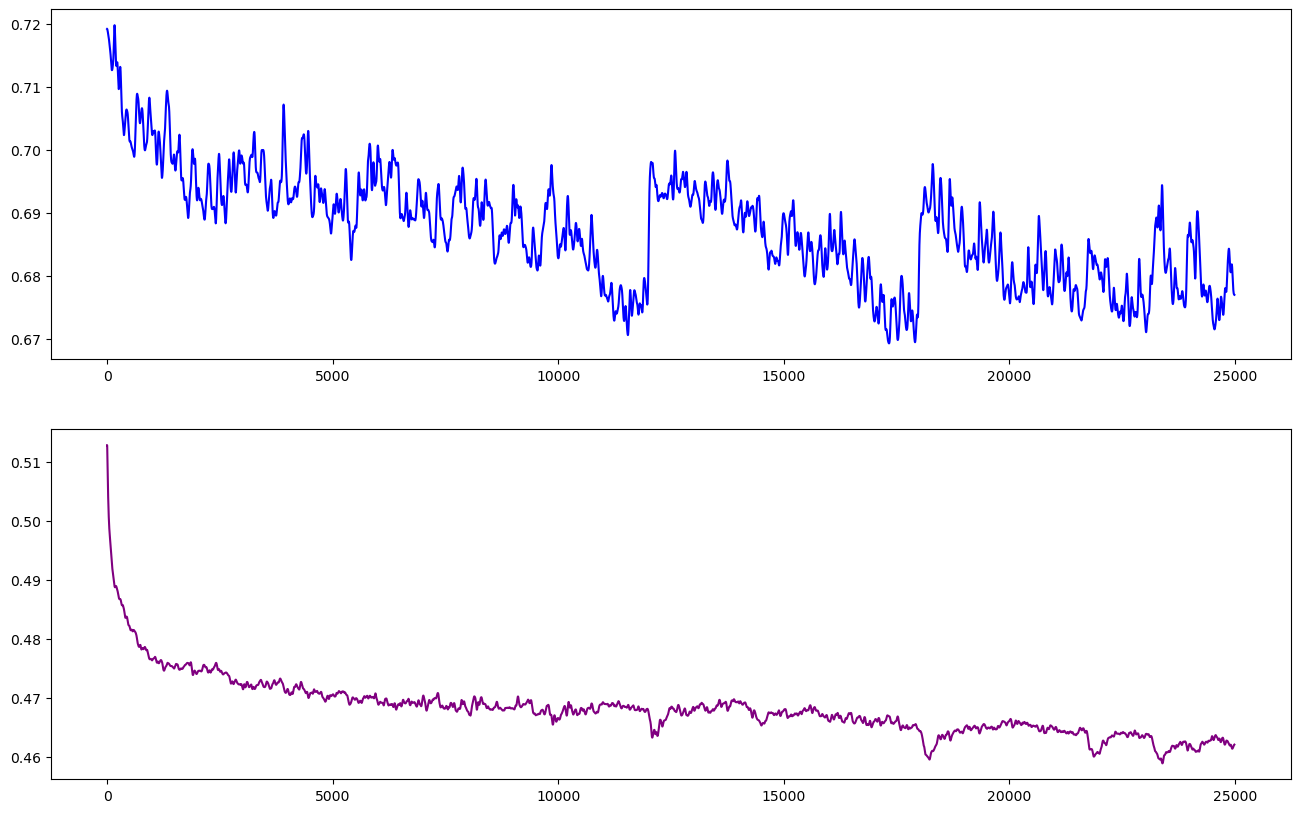

In [15]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(smooth_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(smooth_reference,'purple',linewidth=1.5)

### Find the baseline

In [16]:
lambd = 5e4 # Adjust lambda to get the best fit
porder = 1
itermax = 50
r_base=airPLS(smooth_reference.T,lambda_=lambd,porder=porder,itermax=itermax)
s_base=airPLS(smooth_signal,lambda_=lambd,porder=porder,itermax=itermax)

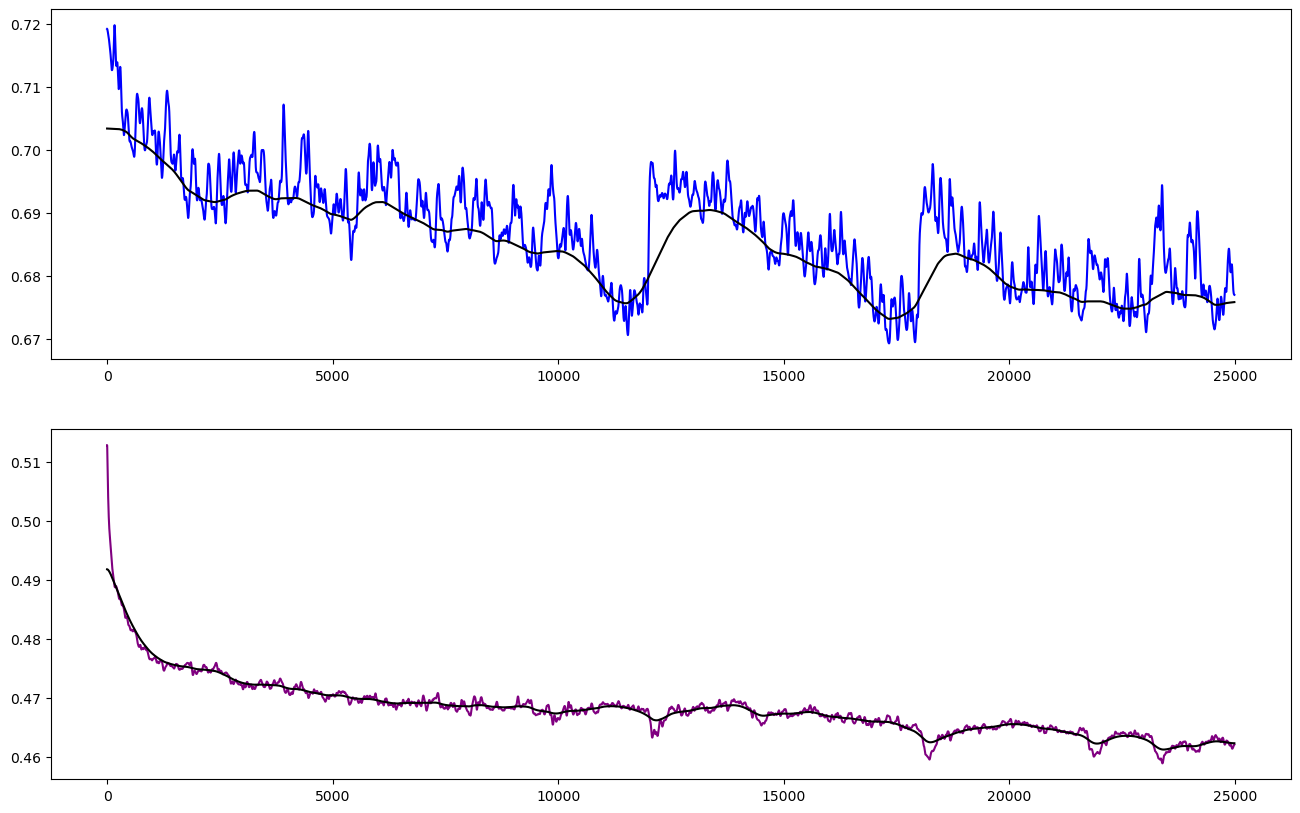

In [17]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(smooth_signal,'blue',linewidth=1.5)
ax1.plot(s_base,'black',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(smooth_reference,'purple',linewidth=1.5)
ax2.plot(r_base,'black',linewidth=1.5)

### Remove the baseline and the beginning of the recordings

In [18]:
remove=200
reference = (smooth_reference[remove:] - r_base[remove:])
signal = (smooth_signal[remove:] - s_base[remove:])  

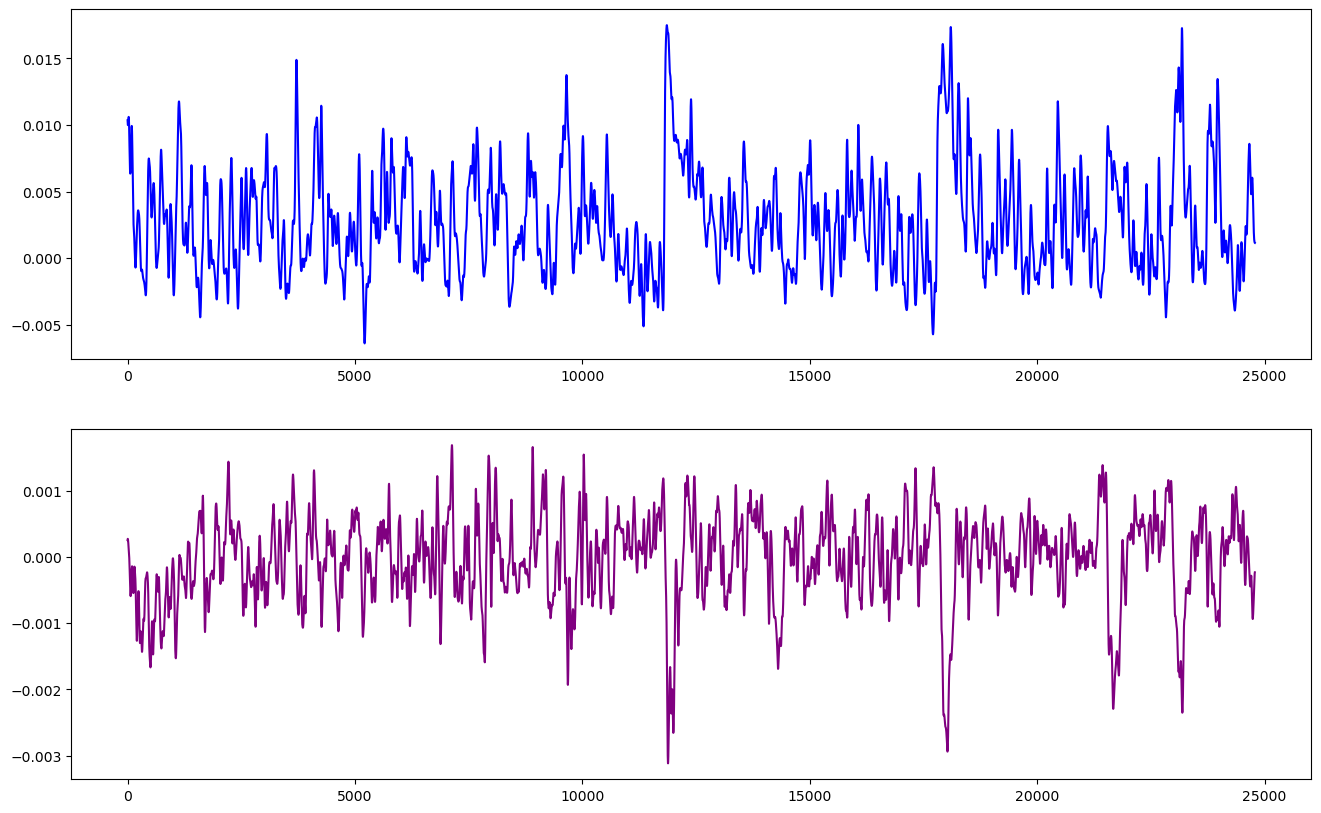

In [19]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(reference,'purple',linewidth=1.5)

### Standardize signals

In [20]:
z_reference = (reference - np.median(reference)) / np.std(reference)
z_signal = (signal - np.median(signal)) / np.std(signal)

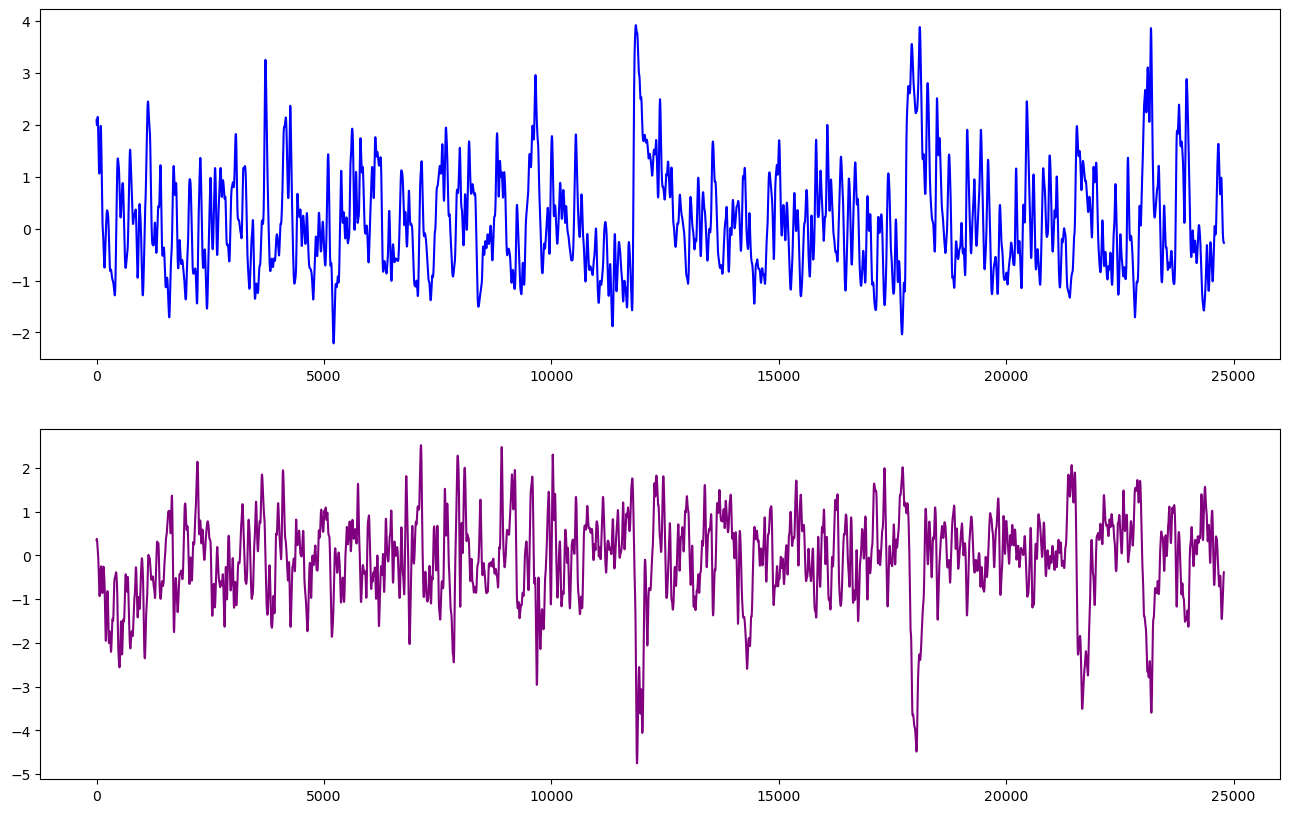

In [21]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(z_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(z_reference,'purple',linewidth=1.5)

### Fit reference signal to calcium signal using linear regression

In [22]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
n = len(z_reference)
lin.fit(z_reference.reshape(n,1), z_signal.reshape(n,1))

Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random')

NameError: name 'z_reference_fitted' is not defined

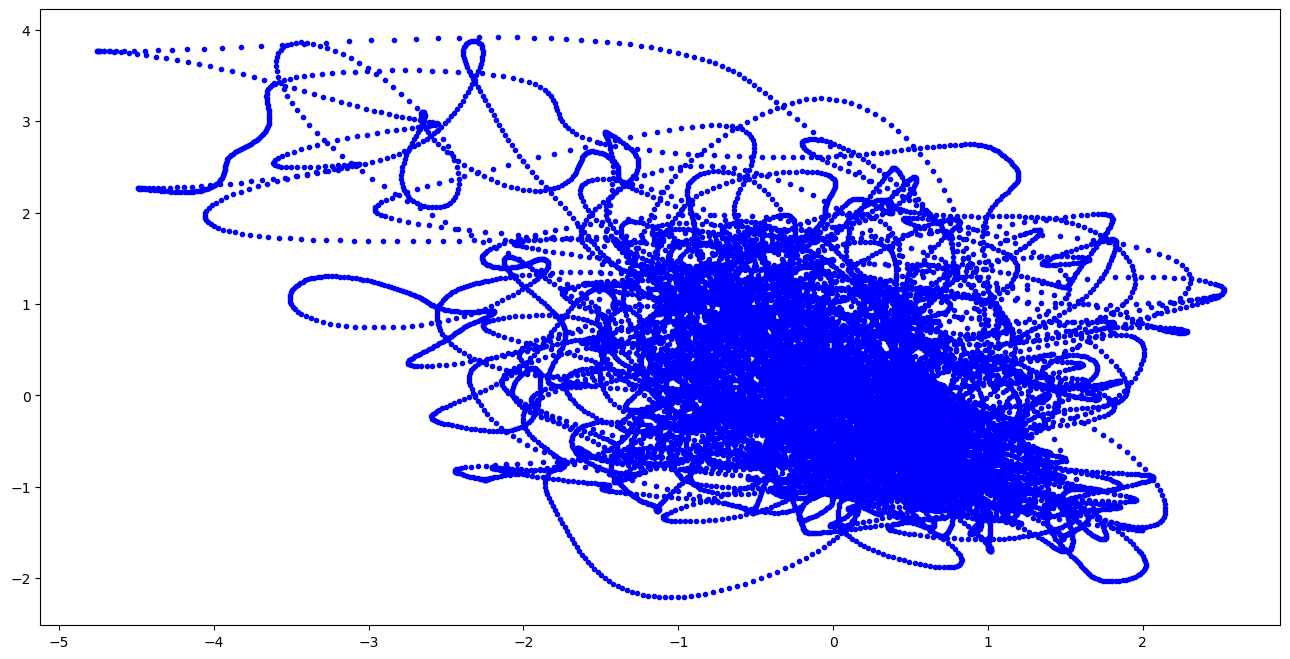

In [23]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z_reference,z_signal,'b.')
ax1.plot(z_reference,z_reference_fitted, 'r--',linewidth=1.5)

### Align reference to signal

In [0]:
z_reference_fitted = lin.predict(z_reference.reshape(n,1)).reshape(n,)

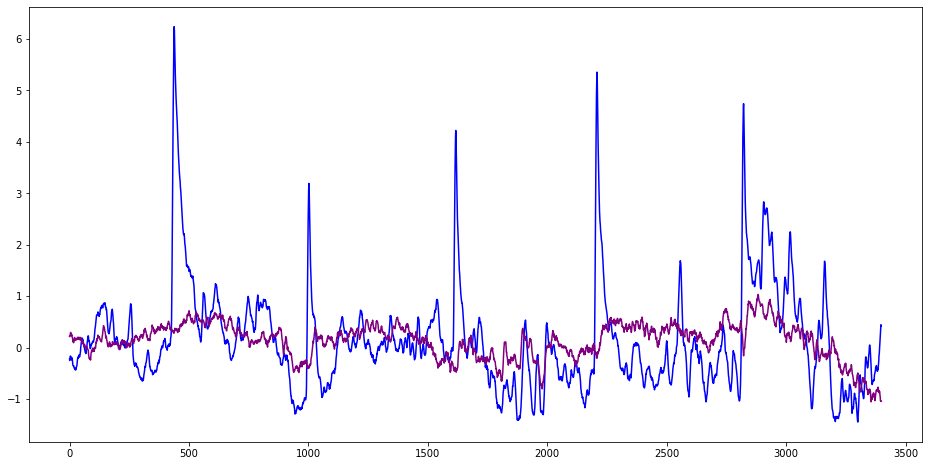

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z_signal,'blue')
ax1.plot(z_reference_fitted,'purple')

### Calculate z-score dF/F

In [0]:
zdFF = (z_signal - z_reference_fitted)

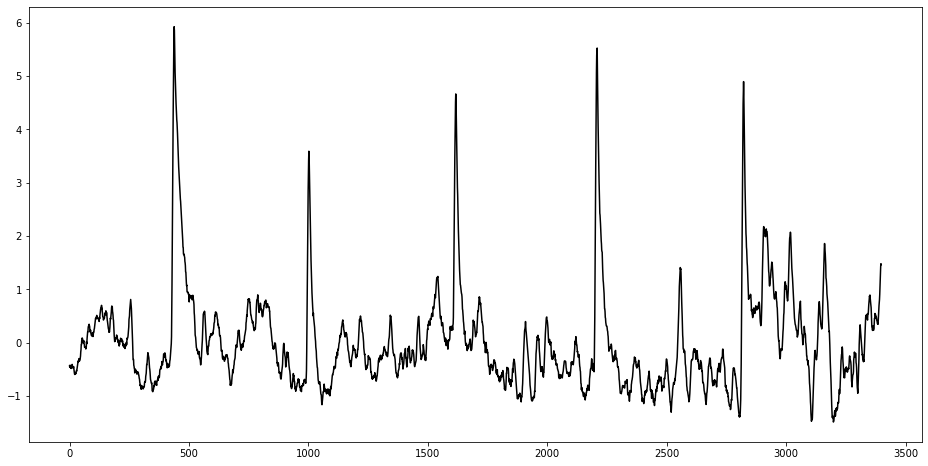

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(zdFF,'black')

# Contact us

If you have any questions please contact us: ekaterina.martianova.1@ulaval.ca

# Functions

Run (Shift+Enter or Ctrl+Enter) the following 3 code cells in order to use functions.


## z-score dF/F

In [0]:
'''
get_zdFF.py calculates standardized dF/F signal based on calcium-idependent 
and calcium-dependent signals commonly recorded using fiber photometry calcium imaging

Ocober 2019 Ekaterina Martianova ekaterina.martianova.1@ulaval.ca 

Reference:
  (1) Martianova, E., Aronson, S., Proulx, C.D. Multi-Fiber Photometry 
      to Record Neural Activity in Freely Moving Animal. J. Vis. Exp. 
      (152), e60278, doi:10.3791/60278 (2019)
      https://www.jove.com/video/60278/multi-fiber-photometry-to-record-neural-activity-freely-moving

'''

def get_zdFF(reference,signal,smooth_win=10,remove=200,lambd=5e4,porder=1,itermax=50): 
  '''
  Calculates z-score dF/F signal based on fiber photometry calcium-idependent 
  and calcium-dependent signals
  
  Input
      reference: calcium-independent signal (usually 405-420 nm excitation), 1D array
      signal: calcium-dependent signal (usually 465-490 nm excitation for 
                   green fluorescent proteins, or ~560 nm for red), 1D array
      smooth_win: window for moving average smooth, integer
      remove: the beginning of the traces with a big slope one would like to remove, integer
      Inputs for airPLS:
      lambd: parameter that can be adjusted by user. The larger lambda is,  
              the smoother the resulting background, z
      porder: adaptive iteratively reweighted penalized least squares for baseline fitting
      itermax: maximum iteration times
  Output
      zdFF - z-score dF/F, 1D numpy array
  '''
  
  import numpy as np
  from sklearn.linear_model import Lasso

 # Smooth signal
  reference = smooth_signal(reference, smooth_win)
  signal = smooth_signal(signal, smooth_win)
  
 # Remove slope using airPLS algorithm
  r_base=airPLS(reference,lambda_=lambd,porder=porder,itermax=itermax)
  s_base=airPLS(signal,lambda_=lambd,porder=porder,itermax=itermax) 

 # Remove baseline and the begining of recording
  reference = (reference[remove:] - r_base[remove:])
  signal = (signal[remove:] - s_base[remove:])   

 # Standardize signals    
  reference = (reference - np.median(reference)) / np.std(reference)
  signal = (signal - np.median(signal)) / np.std(signal)
  
 # Align reference signal to calcium signal using non-negative robust linear regression
  lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
              positive=True, random_state=9999, selection='random')
  n = len(reference)
  lin.fit(reference.reshape(n,1), signal.reshape(n,1))
  reference = lin.predict(reference.reshape(n,1)).reshape(n,)

 # z dFF    
  zdFF = (signal - reference)
 
  return zdFF

## Smooth signal

In [0]:
def smooth_signal(x,window_len=10,window='flat'):

    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    The code taken from: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
                'flat' window will produce a moving average smoothing.

    output:
        the smoothed signal        
    """

    import numpy as np

    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': # Moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')

    return y[(int(window_len/2)-1):-int(window_len/2)]

## airPLS algorithm

Original code of airPLS

In [0]:
'''
airPLS.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
Baseline correction using adaptive iteratively reweighted penalized least squares

This program is a translation in python of the R source code of airPLS version 2.0
by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls

Reference:
Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive iteratively 
reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

Description from the original documentation:
Baseline drift always blurs or even swamps signals and deteriorates analytical 
results, particularly in multivariate analysis.  It is necessary to correct baseline 
drift to perform further data analysis. Simple or modified polynomial fitting has 
been found to be effective in some extent. However, this method requires user 
intervention and prone to variability especially in low signal-to-noise ratio 
environments. The proposed adaptive iteratively reweighted Penalized Least Squares
(airPLS) algorithm doesn't require any user intervention and prior information, 
such as detected peaks. It iteratively changes weights of sum squares errors (SSE) 
between the fitted baseline and original signals, and the weights of SSE are obtained 
adaptively using between previously fitted baseline and original signals. This 
baseline estimator is general, fast and flexible in fitting baseline.


LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
'''

import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,
                 the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z
